In [5]:
import netCDF4 as nc
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seawater as csr
from matplotlib import cm

In [6]:
# read in cresm input data
path1="/localdata/xiaoxiaoyu/CRESM"
nc1=Dataset(path1+"/copernicus_200504_prep.nc")
# nc1.set_auto_mask(False)  # x.mask = ma.nomask


In [7]:
lon_curv=nc1.variables['longitude'][:]
lat_curv=nc1.variables['latitude'][:]
z=nc1.variables['depth'][:]*-1
temp=nc1.variables['temperature'][0,:,:,:]  #only use the first date
salt=nc1.variables['salinity'][0,:,:,:]

In [62]:
csr.dens(salt[:,79,138] , temp[:,79,138] , z*-1) 

masked_array(data=[1023.0752481394111, 1023.0797342128026,
                   1023.0844839048482, 1023.0885793208903,
                   1023.0921000893289, 1023.0929335749357,
                   1023.0907050748215, 1023.0867827206778,
                   1023.0803462380783, 1023.0619617421447,
                   1023.0372131933683, 1023.0374878564006,
                   1023.0576287868929, 1023.0745903147068,
                   1023.0942455227868, 1023.108323388298,
                   1023.1268256780369, 1023.1577557233419,
                   1023.1878043088736, 1023.2153067735225,
                   1023.2695795726587, 1023.3810116832874,
                   1023.477800577075, 1023.5327077235771,
                   1023.6044600083084, 1024.2428886179382,
                   1025.188762602253, 1026.1600066218105,
                   1026.7087088981607, 1027.0874490028611,
                   1027.4386443108658, 1027.7370872907784,
                   1027.9740074348058, 1028.1760484067484,


In [58]:
# step 1 计算 temperature mixed layer 和 blt 确定你要改的区域
np.shape(temp)


(74, 153, 325)

In [9]:
density=np.full_like(temp,None)
[rows, cols]=temp[0,:,:].shape
for j in range(cols-1):
    for i in range(rows-1):
        density[:,i,j] = csr.dens(salt[:,i,j] , temp[:,i,j] , z*-1)   # depth should be postive

In [38]:
# calculate the mld by temperature
# z 的正负 没有关系  
def mld_temp(temp, z):
    # default: 10m layer is in the ind=1 layer 
    # ind_10m=np.where((z<-9)&(z>-11))[0][0]
    ind_10m=7
    for index, dep in enumerate(z[ind_10m::]):
        if temp[index+ind_10m]<temp[ind_10m]-0.2:
            return dep*-1
            break

In [15]:
mld_t=np.full_like(temp[0,:,:],None)
for j in range(cols-1):
    for i in range(rows-1):
        mld_t[i,j]=mld_temp(temp[:,i,j],z)
        # depth should be negative, the result is also negative

In [ ]:
temp[:,79,138]

In [39]:
# http://www.ifremer.fr/cerweb/deboyer/mld/Surface_Mixed_Layer_Depth.php 
# calculate density mld
#  计算位势密度
# 输入的z 是负数！！！！

def mld_density(temp,salt,z):
    # temp, salt is 1d, only has the depth
    # default: 10m layer is in the ind=1 layer 
    density_profiles = csr.dens(salt, temp, 0)  #the origianl density
    ind_10m=7
    # calculate the critical density 
    #ind_10m=np.where((z<-9)&(z>-11))[0][0]
    
    delta_density=csr.dens(salt[ind_10m], temp[ind_10m]-0.2, 0)-csr.dens(salt[ind_10m], temp[ind_10m], 0)
#     print(delta_density)
    density_zero=density_profiles[ind_10m]+delta_density
    
    rou0=min(density_profiles, key=lambda x:abs(x-density_zero))
    ind=np.argwhere(density_profiles==rou0)
    if ind.size==0:
        return None
    else:
        return z[ind][0][0]*-1

In [18]:
mld_r=np.full_like(temp[0,:,:],None)
for j in range(cols-1):
    for i in range(rows-1):
        mld_r[i,j]=mld_density(temp[:,i,j],salt[:,i,j],z)  
        # depth should be negative, the result is also negative

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/seawater/eos80.py:465: RuntimeWarning: invalid value encountered in true_divide
  return densP0 / (1 - p / K)


In [19]:
def replace_salt(salt_1d,z,mld_t_1d):
    depth_ind=np.where(z==mld_t_1d)[0][0]
    salt0=salt_1d[depth_ind]
    salt_1d[:depth_ind]=np.full_like(salt_1d[:depth_ind],salt0)
    return salt_1d

In [54]:
# step 2: change all the BLT in the domain? 
# for each point, if the blt > 10m, then, replace the salt with salt0 (salt at mld_t)
# At the same time, 
salt3=salt
for j in range(25,cols-24):
    for i in range(25,rows-24):
        mld_t_1d=mld_t[i,j]
        if mld_t_1d>=5:
            salt_1d=salt[:,i,j]
            salt1=replace_salt(salt_1d,z*-1,mld_t_1d)  # depth should be postive
            salt3[:,i,j]=salt1

Text(0.5,1,'salinity difference after remove the blt')

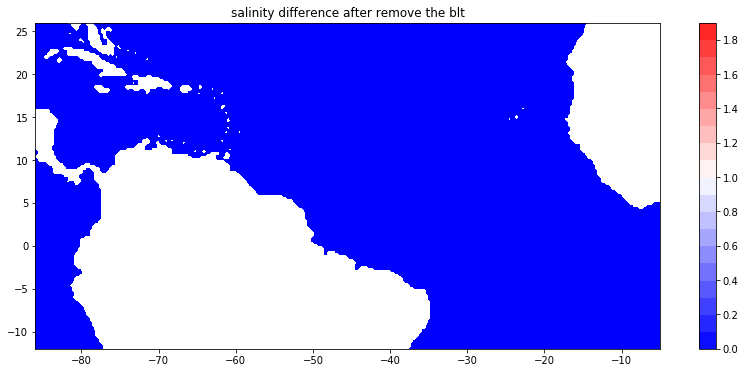

In [55]:
saltd=salt3[7,:,:]-salt[7,:,:]
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, saltd, 20, vmin=0, vmax=2, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
# plt.colorbar(p, ax=ax)  #
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(blt)
m.set_clim(0,2)
plt.colorbar(m, boundaries=np.arange(0,2,0.1))  #
ax.set_title('salinity difference after remove the blt')

In [43]:
# 画改过之后的图
# 先计算改过之后的density, 检查是不是有 reverse
density2=density
for j in range(25,cols-24):
    for i in range(25,rows-24):
        density2[:,i,j] = csr.dens(salt2[:,i,j] , temp[:,i,j] , z*-1)   # depth should be postive

In [44]:
mld_r2=mld_r
for j in range(25,cols-24):
    for i in range(25,rows-24):
        mld_r2[i,j]=mld_density(temp[:,i,j],salt2[:,i,j],z)

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/seawater/eos80.py:465: RuntimeWarning: invalid value encountered in true_divide
  return densP0 / (1 - p / K)


Text(0.5,1,'CRESM density mld on Day 14th')

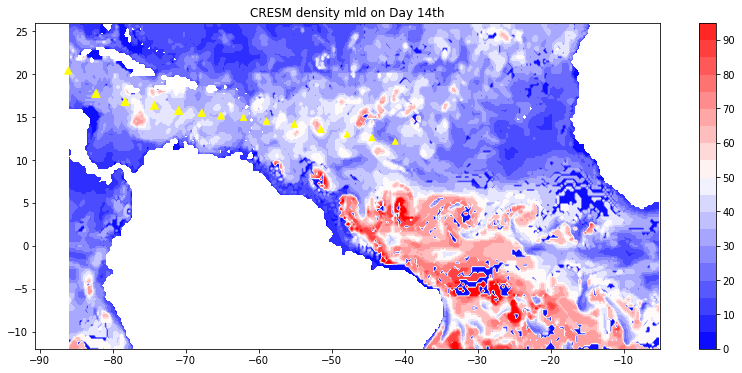

In [45]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, mld_r, 20, vmin=0, vmax=100, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(mld_r)
m.set_clim(0,100)
plt.colorbar(m, boundaries=np.arange(0,100,5))  #
xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
ax.set_title('CRESM density mld on Day 14th')

Text(0.5,1,'CRESM temp mld on Day 14th')

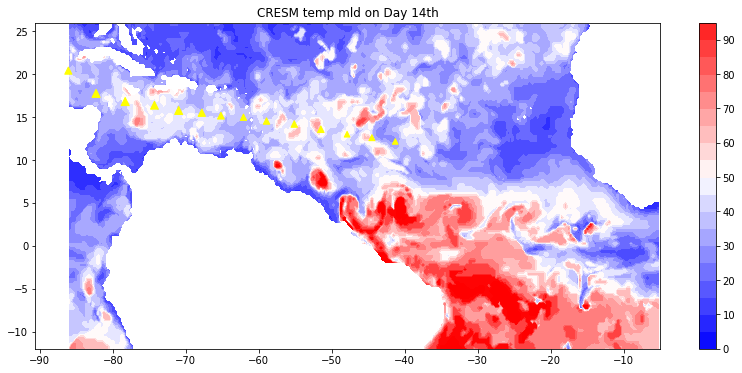

In [46]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, mld_t, 20, vmin=0, vmax=100, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(mld_t)
m.set_clim(0,100)
plt.colorbar(m, boundaries=np.arange(0,100,5))  #
xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
ax.set_title('CRESM temp mld on Day 14th')

Text(0.5,1,'CRESM blt on Day 14th')

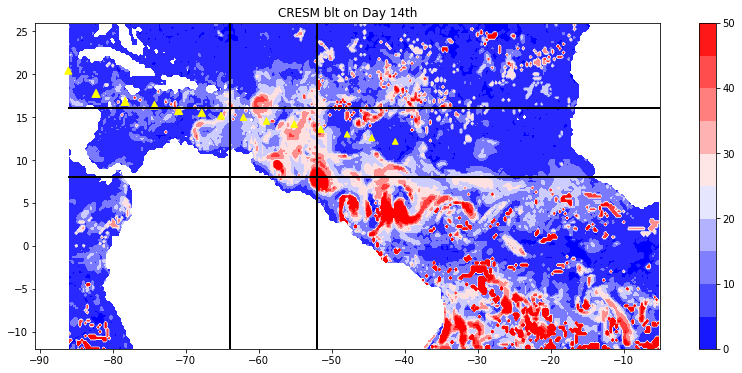

In [47]:

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, blt, 20, vmin=0, vmax=50, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
# plt.colorbar(p, ax=ax)  #
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(blt)
m.set_clim(0,50)
plt.colorbar(m, boundaries=np.arange(0,55,5))  #

xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")


lat = [8, 16] 
lon = [-64, -52] 

x=[-86, -5]
y=[lat[0],lat[0]]
plt.plot(x, y, '-', linewidth=2, color='k') 
y=[lat[1],lat[1]]
plt.plot(x, y, '-', linewidth=2, color='k') 

x=[lon[0],lon[0]]
y=[-12,26]
plt.plot(x, y, '-', linewidth=2, color='k') 
x=[lon[1],lon[1]]
plt.plot(x, y, '-', linewidth=2, color='k') 

ax.set_title('CRESM blt on Day 14th')

Text(0.5,1,'salinity difference after remove the blt')

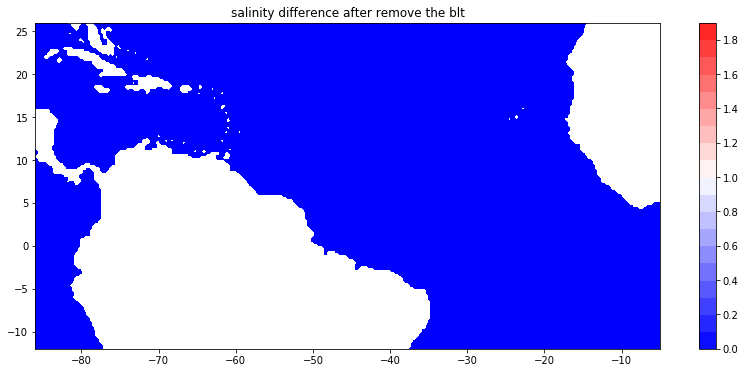

Text(0.5,1,'salinity difference after remove the blt')

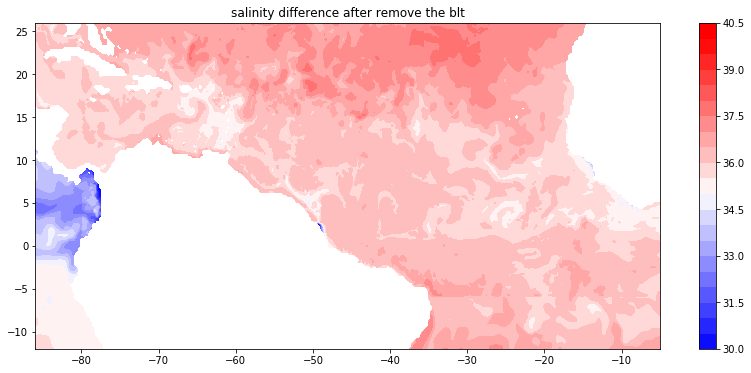

In [315]:

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, salt2[10,:,:], 20, vmin=30, vmax=40, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
# plt.colorbar(p, ax=ax)  #
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(blt)
m.set_clim(30,40)
plt.colorbar(m, boundaries=np.arange(30,41,0.5))  #
ax.set_title('salinity difference after remove the blt')

Text(0.5,1,'salinity difference after remove the blt')

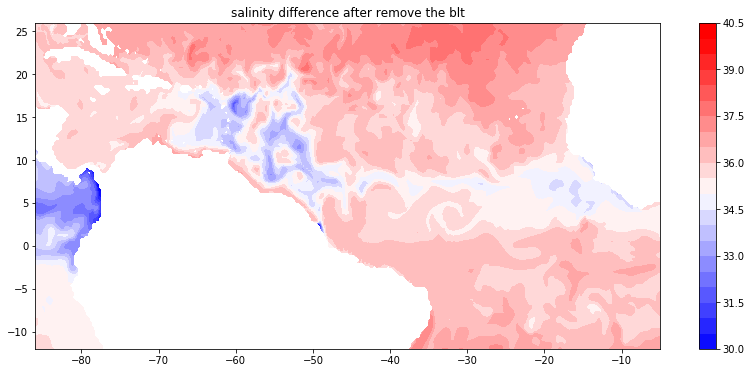

In [316]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, salt[10,:,:], 20, vmin=30, vmax=40, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
# plt.colorbar(p, ax=ax)  #
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(blt)
m.set_clim(30,40)
plt.colorbar(m, boundaries=np.arange(30,41,0.5))  #
ax.set_title('salinity difference after remove the blt')

In [221]:
N=28
lat0_max_ind=79
z[0:N]

masked_array(data=[  -0.50576 ,   -1.555855,   -2.667682,   -3.85628 ,
                     -5.140361,   -6.543034,   -8.092519,   -9.82275 ,
                    -11.77368 ,  -13.99104 ,  -16.52532 ,  -19.4298  ,
                    -22.75762 ,  -26.5583  ,  -30.87456 ,  -35.7402  ,
                    -41.18002 ,  -47.21189 ,  -53.85064 ,  -61.11284 ,
                    -69.02168 ,  -77.61116 ,  -86.92943 ,  -97.04131 ,
                   -108.0303  , -120.      , -133.0758  , -147.4062  ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

Text(0.5,1,'density 7.75°N after change')

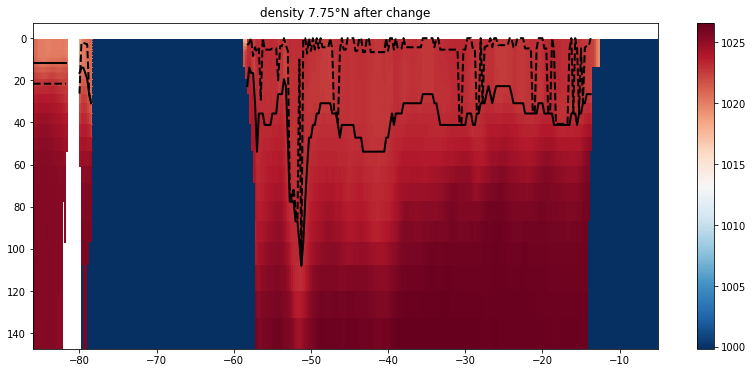

In [325]:
N=28
lat0_max_ind=79
depth=z[0:N]*-1
date=lon_curv
blt_temp=blt2[lat0_max_ind,:]
mld_temp=mld_t2[lat0_max_ind,:]
fig = plt.figure(figsize=(14,6))
ax2 = fig.add_subplot(1, 1, 1)
Xi, Yi = np.meshgrid(date, depth)
ax2.plot(date, mld_temp, linewidth=2, color='k')
ax2.plot(date, blt_temp, linewidth=2, color='k',linestyle='--')
cntr1=ax2.pcolormesh(Xi, Yi, density2[0:N,lat0_max_ind,:], cmap="RdBu_r")
cb = fig.colorbar(cntr1) 
# , vmin=34.5, vmax=36.5
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_title('density '+str(lat_curv[lat0_max_ind])+'°N after change')

In [227]:


def plot_profile_blt_oneline(temp1,salt1,depth,point_str,ild1,mld1):
    # use temp and salt to calulate density, then use depth to calculate BLT, ILD, MLD
    #  plot the ILD, MLD lines
    #  add the salinity 
    #  point_str,date are string 

    t=depth
    ild1=ild1*-1
    mld1=mld1*-1
    dens1 = csr.dens(salt1, temp1, -1*t)   # use this function to calulate density  
    
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    fig = plt.figure(1, (6, 8))
    ax1 = host_subplot(111, axes_class=AA.Axes)
    color = 'tab:red'
    ax1.set_xlabel('Temp (.C)', color=color)
    ax1.set_ylabel(point_str, color='black')
    ax1.plot(temp1, t, color=color,label="before ILD")       
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.grid(True, linestyle='-.',lw=0.4)

    tempmin=21
    tempmax=30
    ax1.set_xlim(tempmin, tempmax)
    ax1.plot([tempmin, tempmax], [mld1, mld1], linestyle ='-',lw=1, color=color)
    ax1.text(tempmax, mld1, ' MLD'+str(mld1), fontsize=10, color=color)
   
    ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    color = 'black'
    ax2.plot(dens1,t, color=color,label="before MLD")
    densmin=1021
    densmax=1026.5
    ax2.set_xlim(densmin, densmax)
    ax2.plot([densmin, densmax], [ild1, ild1], linestyle ='--',lw=1, color=color)
    ax2.text(densmax, ild1,' ILD'+str(ild1), fontsize=10, color=color)
      #设置坐标轴摆放位置和距离
    offset = 0
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["top"] = new_fixed_axis(loc="top",axes=ax2,offset=( 0,offset))
    ax2.axis["top"].toggle(all=True)
    ax2.set_xlabel('Density (kg/m3)', color=color)  # we already handled the x-label with ax1
    ax2.tick_params(axis='x', labelcolor=color)
    

    ax3 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax3.plot(salt1,t, color=color,label="salinity")

    saltmin= 34
    saltmax= 36.5
    ax3.set_xlim(saltmin, saltmax)
    
    #设置坐标轴摆放位置和距离
    offset = 40
    new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    ax3.axis["top"] = new_fixed_axis(loc="top",axes=ax3,offset=( 0,offset))
    ax3.axis["top"].toggle(all=True)
    ax3.set_xlabel('Salinity (psu)', color=color)
    ax3.tick_params(axis='top', labelcolor=color)
    

#     fig.tight_layout()
    return plt.show()


In [228]:
lon0_max_ind=138
# print(np.shape(np.where(blt2[lat0_max_ind,:]>=20)))
lat_pick=np.where(blt2[:,lon0_max_ind]>=20)
print(lat_pick)
# lon0_max_ind=29
print(lat_curv[lat_pick])
blt2[lat_pick,lon0_max_ind]

(array([ 73,  74,  77,  78,  80,  86, 131, 132, 133, 134, 135, 137, 142]),)
[ 6.25  6.5   7.25  7.5   8.    9.5  20.75 21.   21.25 21.5  21.75 22.25
 23.5 ]


masked_array(data=[[24.331525325775146, 42.07153034210205,
                    107.52453631162643, 107.52453631162643,
                    86.42366808652878, 53.34487932920456,
                    20.65359115600586, 24.45427131652832,
                    22.9760799407959, 27.292339324951172,
                    31.093019485473633, 24.45427131652832,
                    27.78209114074707]],
             mask=[[False, False, False, False, False, False, False,
                    False, False, False, False, False, False]],
       fill_value=-32767.0)

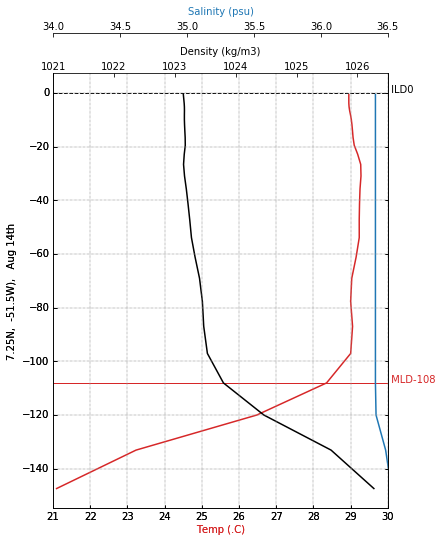

In [254]:

# np.shape(blt2)
lat0_bad=77
lon0_bad=138
lat_c=lat_curv[lat0_bad]
lon_c=lon_curv[lon0_bad]
depth=z[0:N]
N=28
dens0_bad=density2[0:N,lat0_bad,lon0_bad]
salt0_bad=salt2[0:N,lat0_bad,lon0_bad]
temp0_bad=temp[0:N,lat0_bad,lon0_bad]
ild1=int(mld_r2[lat0_bad,lon0_bad])
mld1=int(mld_t2[lat0_bad,lon0_bad])
point_str=str(lat_c)+"N,  "+str(lon_c)+"W),   Aug 14th"
plot_profile_blt_oneline(temp0_bad,salt0_bad,depth,point_str,ild1,mld1)

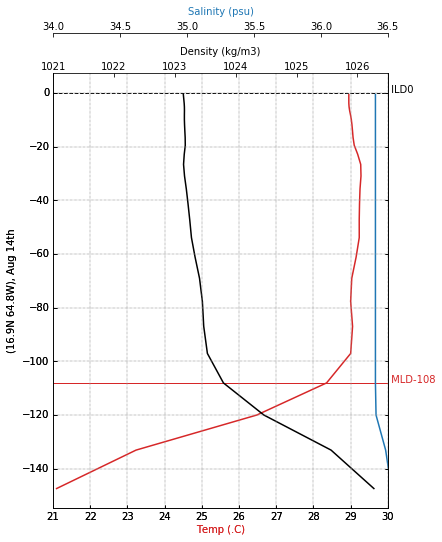

[36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.411633621901274 36.483352119103074 36.52607803232968]
[36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.40705584548414 36.40705584548414 36.40705584548414
 36.40705584548414 36.411633621901274 36.4833521

In [255]:
dens_bad=density[0:N,lat0_bad,lon0_bad]
salt_bad=salt[0:N,lat0_bad,lon0_bad]
ild=int(mld_r[lat0_bad,lon0_bad])
mld=int(mld_t[lat0_bad,lon0_bad])
point_str="(16.9N 64.8W), Aug 14th"
plot_profile_blt_oneline(temp0_bad,salt_bad,depth,point_str,ild,mld)
print(salt[0:N,lat0_bad,lon0_bad])
print(salt2[0:N,lat0_bad,lon0_bad])
print(mld1)
print(ild1)

Text(0.5,1,'CRESM density mld on Day 14th after change')

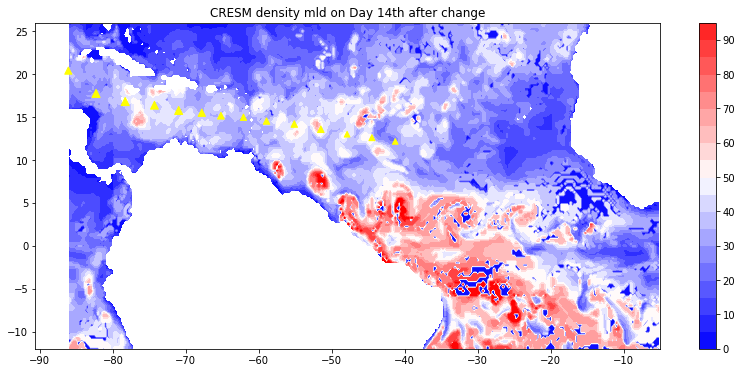

In [89]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, mld_r2, 20, vmin=0, vmax=100, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(mld_r2)
m.set_clim(0,100)
plt.colorbar(m, boundaries=np.arange(0,100,5))  #
xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
ax.set_title('CRESM density mld on Day 14th after change')

Text(0.5,1,'CRESM blt on Day 14th')

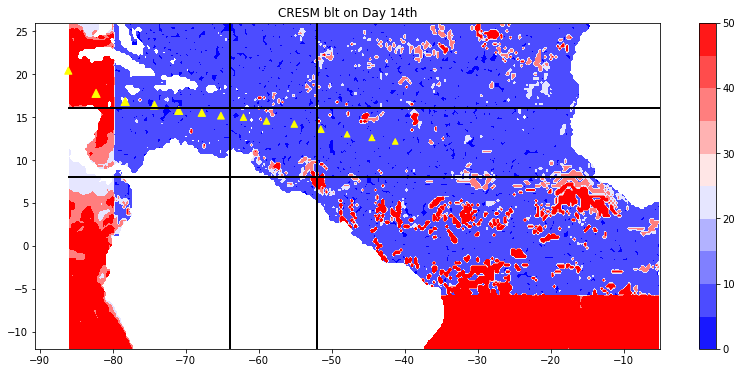

In [256]:

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, blt2, 20, vmin=0, vmax=50, cmap=cm.bwr)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
# plt.colorbar(p, ax=ax)  #
m = plt.cm.ScalarMappable(cmap=cm.bwr)
m.set_array(blt2)
m.set_clim(0,50)
plt.colorbar(m, boundaries=np.arange(0,55,5))  #

xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")


lat = [8, 16] 
lon = [-64, -52] 

x=[-86, -5]
y=[lat[0],lat[0]]
plt.plot(x, y, '-', linewidth=2, color='k') 
y=[lat[1],lat[1]]
plt.plot(x, y, '-', linewidth=2, color='k') 

x=[lon[0],lon[0]]
y=[-12,26]
plt.plot(x, y, '-', linewidth=2, color='k') 
x=[lon[1],lon[1]]
plt.plot(x, y, '-', linewidth=2, color='k') 

ax.set_title('CRESM blt on Day 14th')

In [261]:
# find the maximum mld_t
# np.ma.max(mld_t)
# 画profile
masked_X = np.ma.masked_invalid(mld_t, copy=False)
mldt_max=int(np.max(masked_X))
mldt_max_ind=np.where(z==mldt_max)
mldt_max_ind_2d=np.where(mld_t==mldt_max)
# print(mldt_max_ind_2d)
lat0_max_ind=79
lon0_max_ind=138
print(lat_curv[lat0_max_ind])
print(lon_curv[lon0_max_ind])
lat0_max_ind=110
print(lat_curv[lat0_max_ind])
lon0_max_ind=90
print(lon_curv[lon0_max_ind])

7.75
-51.5
15.5
-63.5


-63.5


Text(0.5,1,'salinity after change')

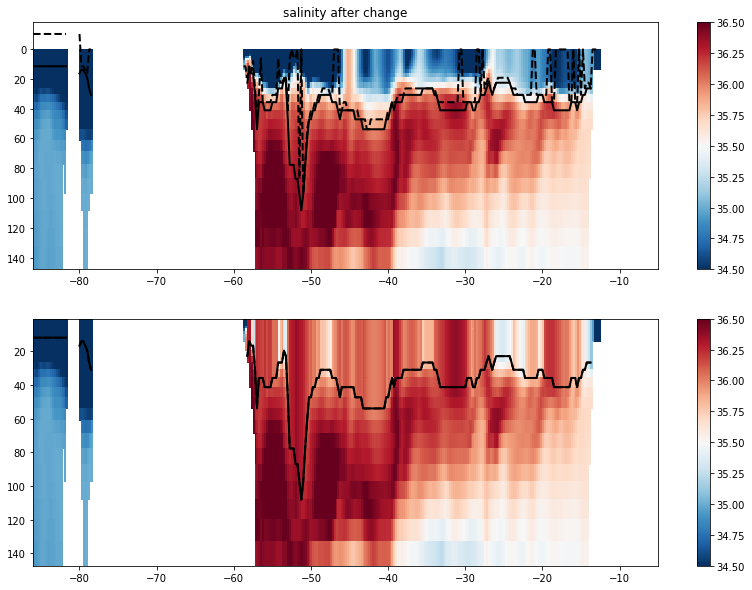

In [329]:
# 画图

# lat0_max_ind=110  #15.5N
# lat0_max_ind=79  #7.75N
# lon0_max_ind=138   #51.5
lon0_max_ind=90
print(lon_curv[lon0_max_ind])

N=28
depth=z[0:N]*-1
date=lon_curv
mld_t_temp=mld_t[lat0_max_ind,:]
mld_r_temp=mld_r[lat0_max_ind,:]*-1

fig = plt.figure(figsize=(14,10))

ax2 = fig.add_subplot(2, 1, 1)
Xi, Yi = np.meshgrid(date, depth)
ax2.plot(date, mld_t_temp, linewidth=2, color='k')
ax2.plot(date, mld_r_temp, linewidth=2, color='k',linestyle='--')
cntr1=ax2.pcolormesh(Xi, Yi, salt[0:N,lat0_max_ind,:], vmin=34.5, vmax=36.5, cmap="RdBu_r")
cb = fig.colorbar(cntr1) 
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_title('salinity '+str(lat_curv[lat0_max_ind])+'°N before change')

mld_t_temp2=mld_t2[lat0_max_ind,:]
mld_r_temp2=mld_r2[lat0_max_ind,:]

ax3 = fig.add_subplot(2, 1, 2)
ax3.plot(date, mld_t_temp2, linewidth=2, color='k')
ax3.plot(date, mld_r_temp2, linewidth=2, color='k',linestyle='--')
cntr3=ax3.pcolormesh(Xi, Yi, salt2[0:N,lat0_max_ind,:], vmin=34.5, vmax=36.5, cmap="RdBu_r")
cb = fig.colorbar(cntr3) 
ax3.set_ylim(ax3.get_ylim()[::-1])
ax2.set_title('salinity after change')

-51.5


(147.4062042236328, 0.5057600140571594)

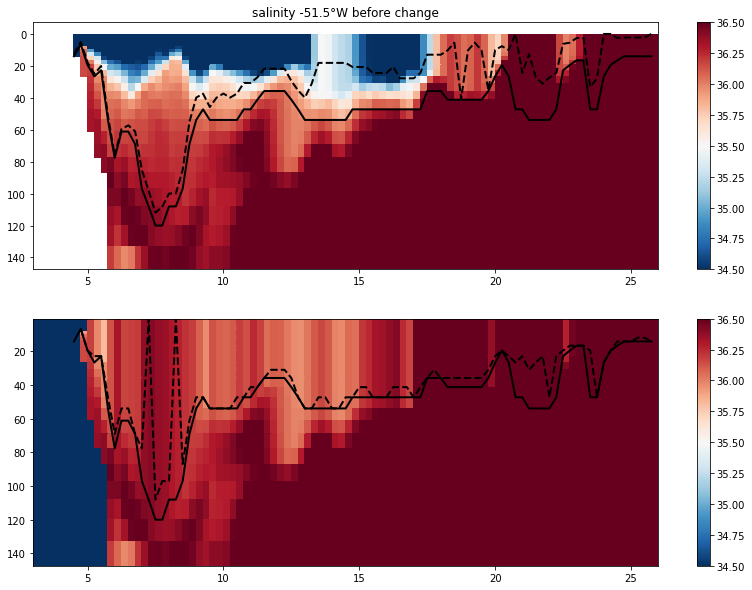

In [130]:
# 画图

# lat0_max_ind=110  #15.5N
# lat0_max_ind=79  #7.75N
# lon0_max_ind=138   #51.5

lon0_max_ind=138
print(lon_curv[lon0_max_ind])

N=28
lat_n1=60
depth=z[0:N]
date=lat_curv[lat_n1::]

mld_t2_temp=mld_t[lat_n1::,lon0_max_ind]
mld_r2_temp=mld_r[lat_n1::,lon0_max_ind]

fig = plt.figure(figsize=(14,10))
ax2 = fig.add_subplot(2, 1, 1)
Xi, Yi = np.meshgrid(date, depth)
ax2.plot(date, mld_t2_temp, linewidth=2, color='k')
ax2.plot(date, blt2_temp, linewidth=2, color='k',linestyle='--')
cntr1=ax2.pcolormesh(Xi, Yi, salt[0:N,lat_n1::,lon0_max_ind], vmin=34.5, vmax=36.5, cmap="RdBu_r")
cb = fig.colorbar(cntr1) 
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_title('salinity '+str(lon_curv[lon0_max_ind])+'°W before change')

mld_t2_temp2=mld_t2[lat_n1::,lon0_max_ind]
mld_r2_temp2=mld_r2[lat_n1::,lon0_max_ind]

ax3 = fig.add_subplot(2, 1, 2)
ax3.plot(date, mld_t2_temp2, linewidth=2, color='k')
ax3.plot(date, mld_r2_temp2, linewidth=2, color='k',linestyle='--')
cntr3=ax3.pcolormesh(Xi, Yi, salt2[0:N,lat_n1::,lon0_max_ind], vmin=34.5, vmax=36.5, cmap="RdBu_r")
cb = fig.colorbar(cntr3) 
ax3.set_ylim(ax3.get_ylim()[::-1])


In [162]:
# function about replace the salt with salt0
# 找到你想要得那个点的位置
# for example: working
# # #  Firstly: find the location and make it into 1d
# lat0=lat_curv[(lat_curv<17.1)&(lat_curv>16.8)]
# lat_ind=np.where(lat_curv==lat0)[0][0]
# lon0=lon_curv[(lon_curv>-65)&(lon_curv<-64.5)]
# lon_ind=np.where(lon_curv==lon0)[0][0]
# salt_1d=salt[:,lat_ind,lon_ind]
# mld_t_1d=mld_t[lat_ind,lon_ind]
# salt1=replace_salt(salt_1d,z,mld_t_1d)
salt=nc1.variables['salinity'][0,:,:,:]
salt2[:,lat_ind+2,lon_ind]

masked_array(data=[35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.233619157224894, 35.233619157224894,
                   35.52812277339399, 35.82567824050784,
                   36.08813742175698, 36.349070677533746,
                   36.614581709727645, 36.85110015794635,
                   37.01895195990801, 37.12271489202976,
                   37.19443338923156, 37.13950007222593,
                   37.035737140104175, 36.90908532589674,
                   36.74123352393508, 36.590166902169585,
                   36.46809286437929, 36.35822623036802,
         

In [384]:
# 保存文件
# 首先copy旧文件里面的所有变量到新的文件，然后添加一个新的变量
src=Dataset(path1+"/copernicus_200504.nc")
trg=Dataset(path1+"/copernicus_200504_5.nc","w", format='NETCDF4')
# src.dimensions.items()

OSError: [Errno -101] NetCDF: HDF error: b'/localdata/xiaoxiaoyu/CRESM/copernicus_200504.nc'

In [ ]:
# create the dimensions of the file
for name, dim in src.dimensions.items():
    trg.createDimension(name)

In [373]:
f=Dataset(path1+"/copernicus_200504_4.nc","w", format='NETCDF4')
salt0=nc1.variables['salinity'][:,:,:,:]
s2=salt0
s2[0,:,:,:]=salt2

In [374]:
nc1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: daily mean from GLORYS2V4
    institution: MERCATOR OCEAN
    references: http://www.mercator-ocean.fr
    source: MERCATOR GLORYS2V4
    Conventions: CF-1.0
    history: Wed Jul 11 17:01:52 2018: ncap2 -s temperature=temperature-273.15f copernicus_200504.nc prep_co_tmp1.nc
Data extracted from dataset http://localhost/thredds/dodsC/dataset-global-reanalysis-phy-001-025-ran-fr-glorys2v4-daily
    time_min: 486564.0
    time_max: 486708.0
    julian_day_unit: hours since 1950-01-01 00:00:00
    z_min: 0.5057600140571594
    z_max: 5902.05810546875
    latitude_min: -12.0
    latitude_max: 26.0
    longitude_min: -86.0
    longitude_max: -5.0
    nco_openmp_thread_number: 1
    dimensions(sizes): time(7), depth(74), latitude(153), longitude(325)
    variables(dimensions): float64 temperature(time,depth,latitude,longitude), int16 v(time,depth,latitude,longitude), int16 u(time,depth,l

In [375]:
time = f.createDimension('time', 7)
depth = f.createDimension('depth', 74)
latitude = f.createDimension('latitude', 153)
longitude = f.createDimension('longitude', 325)

In [378]:
np.shape(f.variables["salinity2"])

(7, 74, 153, 325)

In [377]:
f.createVariable("salinity2","f4",("time","depth","latitude","longitude"))
f.variables["salinity2"][:,:,:,:]=s2

In [380]:
f.variables["salinity2"]

<class 'netCDF4._netCDF4.Variable'>
float32 salinity2(time, depth, latitude, longitude)
unlimited dimensions: 
current shape = (7, 74, 153, 325)
filling on, default _FillValue of 9.969209968386869e+36 used

In [381]:
f.close()

In [351]:
f2=Dataset[path1+"copernicus_200504_2.nc","r"]

TypeError: 'type' object is not subscriptable